In [1]:
import pandas as pd
import re
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, TrainerCallback
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


Data Preprocessing

In [3]:
data = pd.read_csv("AI_Human.csv")
data = data.rename(columns={'generated': 'label'})
data['label'] = data['label'].astype(int)

# Text preprocessing
def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\d', '', text)   # Remove numbers
    text = text.lower()              # Convert to lowercase
    text = re.sub(r'\s+', ' ', text) # Remove extra spaces
    return text.strip()

data['text'] = data['text'].apply(preprocess_text)
dataset = Dataset.from_pandas(data)
dataset = dataset.shuffle(seed=42).select(range(50000))

In [4]:
data

,text,label
0,cars cars have been around since they became f...,0
1,transportation is a large necessity in most co...,0
2,america s love affair with it s vehicles seems...,0
3,how often do you ride in a car do you drive a ...,0
4,cars are a wonderful thing they are perhaps on...,0
...,...,...
487230,tie face on mars is really just a big misunder...,0
487231,the whole purpose of democracy is to create a ...,0
487232,i firmly believe that governments worldwide sh...,1
487233,i dfn t agree with this decision because a lft...,0


Tokenization and Dataset Preparation

In [5]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text data
def tokenize_function(d):
    return tokenizer(d['text'], padding="max_length", truncation=True)

# Apply tokenization to the dataset
dataset = dataset.map(tokenize_function, batched=True)
dataset = dataset.remove_columns(['text', 'token_type_ids'])
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Split into training and testing sets
train_test_split = dataset.train_test_split(test_size=0.2)
train_data = train_test_split['train']
test_data = train_test_split['test']

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [6]:
train_data

Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 40000
})

In [7]:
test_data

Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 10000
})

Model Initialization

In [8]:
# Load BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

Define Training Arguments and Trainer

In [9]:
# Define the training arguments
saveSteps = 500
training_args = TrainingArguments(
    output_dir='E:\\results',
    evaluation_strategy="epoch",
    save_strategy="steps",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01, #0.1, 0.01
    report_to=[],
    save_steps=saveSteps,
    fp16=True,
)

# Custom callback to record metrics after each epoch
class LossCallback(TrainerCallback):
    def __init__(self):
        self.epoch_metrics = {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        }

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        # Log metrics after each evaluation (at the end of each epoch)
        self.epoch_metrics['accuracy'].append(metrics['eval_accuracy'])
        self.epoch_metrics['precision'].append(metrics['eval_precision'])
        self.epoch_metrics['recall'].append(metrics['eval_recall'])
        self.epoch_metrics['f1'].append(metrics['eval_f1'])

metrics_recorder = LossCallback()

# Define the compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='binary'
    )
    acc = accuracy_score(labels, predictions)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# Trainer setup
trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_data,             
    eval_dataset=test_data,                
    compute_metrics=compute_metrics,
    callbacks=[metrics_recorder]
)

In [10]:
trainer.train()

C:\Users\Robin\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss


TrainOutput(global_step=15000, training_loss=0.03017224367459615, metrics={'train_runtime': 2622.9042, 'train_samples_per_second': 45.751, 'train_steps_per_second': 5.719, 'total_flos': 3.15733266432e+16, 'train_loss': 0.03017224367459615, 'epoch': 3.0})

Evaluate the model by plotting Accuracy, F1 score, Precision and Recall

In [11]:
def evaluate_checkpoint(checkpoint_dir):
    model = BertForSequenceClassification.from_pretrained(checkpoint_dir)
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=test_data,
        compute_metrics=compute_metrics,
    )
    eval_results = trainer.evaluate()
    train_results = trainer.evaluate(train_data)
    return train_results, eval_results

# Collect evaluation metrics for each checkpoint
steps = []
accuracyTrain = []
accuracyTest = []
f1ScoresTrain = []
f1ScoresTest = []
precisionTrain = []
precisionTest = []
recallTrain = []
recallTest = []
stepCount = saveSteps

while stepCount <= 15000:
    train_results, eval_results = evaluate_checkpoint('E:\\results/checkpoint-' + str(stepCount))
    steps.append(stepCount)
    accuracyTrain.append(train_results['eval_accuracy'])
    f1ScoresTrain.append(train_results['eval_f1'])
    precisionTrain.append(train_results['eval_precision'])
    recallTrain.append(train_results['eval_recall'])
    accuracyTest.append(eval_results['eval_accuracy'])
    f1ScoresTest.append(eval_results['eval_f1'])
    precisionTest.append(eval_results['eval_precision'])
    recallTest.append(eval_results['eval_recall'])
    stepCount += saveSteps

Plots

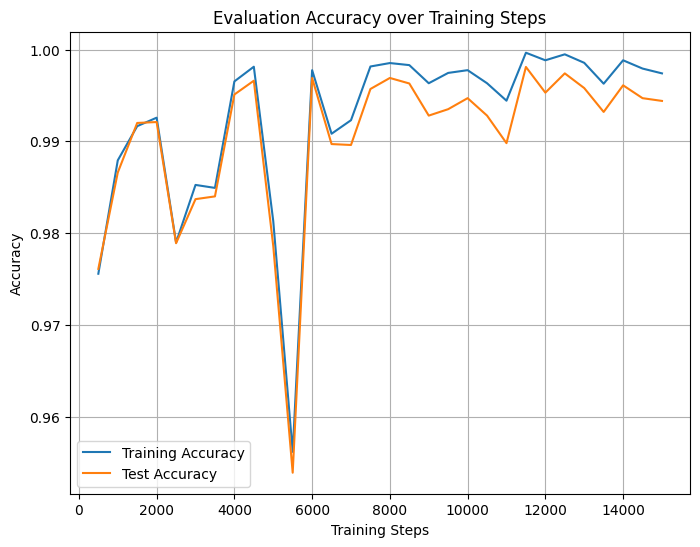

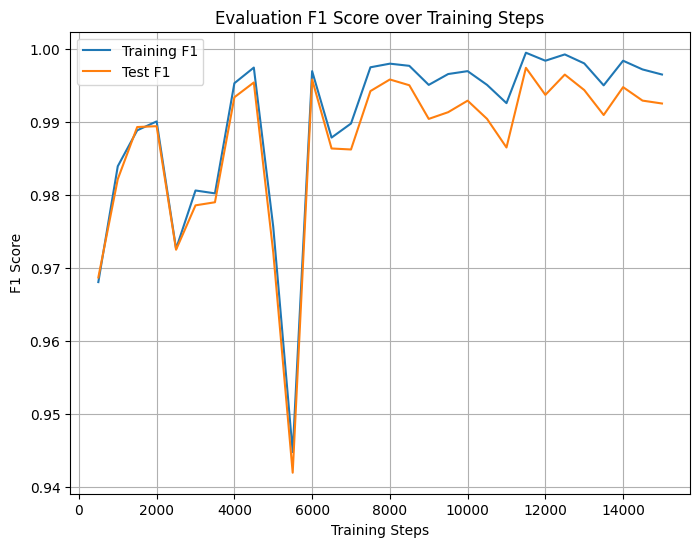

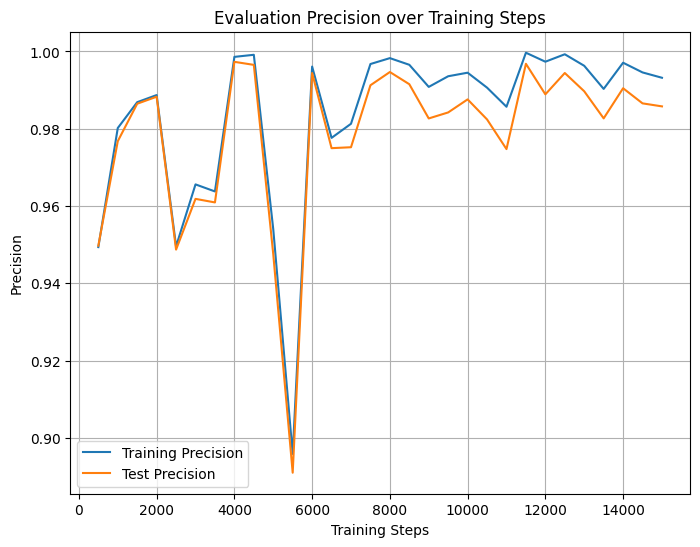

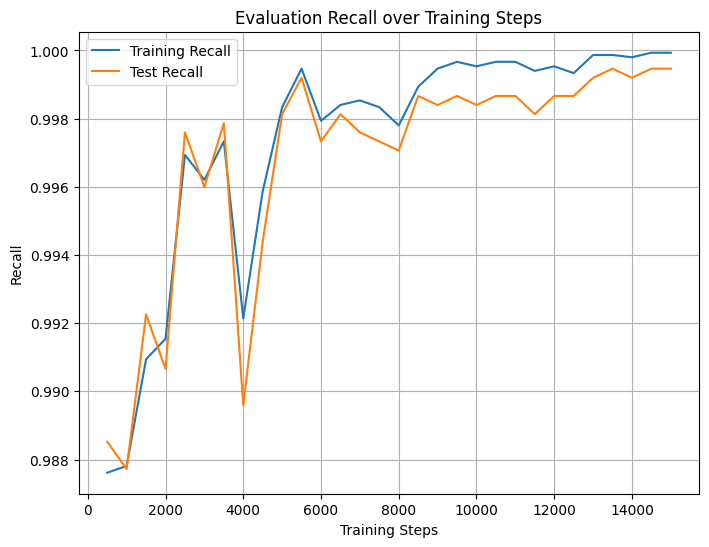

In [12]:
plt.figure(figsize=(8, 6))
plt.plot(steps, accuracyTrain, label="Training Accuracy")
plt.plot(steps, accuracyTest, label="Test Accuracy")
plt.xlabel("Training Steps")
plt.ylabel("Accuracy")
plt.title("Evaluation Accuracy over Training Steps")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(steps, f1ScoresTrain, label="Training F1")
plt.plot(steps, f1ScoresTest, label="Test F1")
plt.xlabel("Training Steps")
plt.ylabel("F1 Score")
plt.title("Evaluation F1 Score over Training Steps")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(steps, precisionTrain, label="Training Precision")
plt.plot(steps, precisionTest, label="Test Precision")
plt.xlabel("Training Steps")
plt.ylabel("Precision")
plt.title("Evaluation Precision over Training Steps")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(steps, recallTrain, label="Training Recall")
plt.plot(steps, recallTest, label="Test Recall")
plt.xlabel("Training Steps")
plt.ylabel("Recall")
plt.title("Evaluation Recall over Training Steps")
plt.legend()
plt.grid()
plt.show()